## Learning rewriting rules for building fractal star clusters

Remember the original goal is to be able to generate synthetic star clusters that share some properties with the real thing. One of these is fractality (non integer fractal dimension). This comes with some self-similarity, i.e. a reasonably big subclump of the initial star cluster still looks like a star cluster. We can build systems of this kind with rewriting rules of some sort. Ideally we should be able to interpret these rewriting rules in terms of the physics of sink particle formation in hydro simulations (turbulence has a scaling symmetry). We are not there yet, though there may be work on this in the literature that we do not know of.

![Rewriting](iterate.png)

Consider a set of particles $S = {p_1, ..., p_N }$. The number of particles in the set is denoted by $|S|$.
Particles are vectors in a suitable space, for exampe $\mathbb{R}^7$, where one coordinate represents mass, three coordinates the position, and three coordinates the velocity. Other quantities can be included as well, in principle.

Let the set of all such finite sets of particles be $\mathbb{S}$. Consider a function $f: \mathbb{S} \to \mathbb{S}$ such that $|f(S)| = |S| + 1$ and $p_i \in S = p_j \in f(S)$ for every $i=j$ such that $i < |S| - 1$. In other words $f$ removes one particle from $S$ and repaces it with two new particles, leaving all other particles untouched.

Let $f$ depend also on some parameters $\mathbf{\theta}$, which we can write as $f_\mathbf{\theta}$. We can apply $f_\mathbf{\theta}$ $N$ times to some set $S_0$, obtaining $f^N_\mathbf{\theta}(S_0)$, which contains $N + |S_0|$ particles. A natural choice for $S_0$ is a set containing only one particle of mass $M$ sitting still at the origin.

This way we can build one set of $N + 1$ particles for any given choice of $\mathbf{\theta}$. We can then use these known $\mathbf{\theta}$s as labels to train a machine learning model to predict $\mathbf{\theta}$ from a given set of $N + 1$ particles (possibly represented as a graph). This can later be used on real data to find $\mathbf{\theta}$s that let us reconstruct this data by applying and $f_\mathbf{\theta}$ repeatedly.

![Learning](learnTheta.png)

The question now is how to parametrize $f_\mathbf{\theta}$ so that its $\mathbf{\theta}$ are easy to learn and expressive enough to build realistic clusters. Additionally, in practice there will be some randomness in building the system; how to model that?

#### Building $f$

We can think of $f$ as the composition of two functions, one that chooses which particle to split and one that chooses how to split it. We could for instance always split the heaviest particle, but some experimentation showed that this leads to unrealistic-looking mass functions. A more flexible generalization is to choose at random the particle to split among the $k$ heaviest particles. Thus $\theta_0 = k$ will be the first parameter in $\mathbf{\theta}$.

After having decided which particle to split, we need to decide where to place the two particles resulting from the split and how to assign a mass to them. We want to conserve mass, so once we set the mass of one of the two new particles, we know the mass of the other. $\theta_1 = \mathit{min}(m_1, m_2)/(m_1 + m_2)$ will be the second parameter in $\mathbf{\theta}$.

We also conserve the center of mass, so we have to decide only how far from each other the new particles will be ($d$), and the direction of the line connecting them (specified by two angles $\phi_1$, $\phi_2$) . We do the same thing in velocity space with the additional constraints of conserving energy and angular momentum (conserving linear momentum is equivalent to conserving the center of mass in position space). But I won't be working in velocity space for now.

If we want isotropy then $\phi_1$ and $\phi_2$ must be chosen at random, uniformly. Moreover, using a fixed $d$ is unrealistic; we want to decrease it as we split. Remember that $d$ is the relative distance at which we place the two offspring particles after a split. It is natural to require it to be small at the end when we will be placing the last particles. We will decrease it exponentially at each step, i.e. $d = \theta_2^N d_0$ with $\theta_2 < 1$. Since the initial set $S_0$ contains only one particle, it has no intrinsic scale, so we can set $d_0 = 1$. We should standardize our coordinates both in training and when predicting on real data.

We are thus left with having to learn three parameters ($\theta_0$, $\theta_1$, and $\theta_2$) if we concentrate only on position space.

In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from itertools import permutations
from torch_geometric.utils import to_networkx
import networkx as nx
import torch
from torch_cluster import knn_graph
from torch_geometric.data import Data
from torch.nn import Linear
import torch.nn.functional as F
from torch_geometric.nn import GCNConv
from torch_geometric.nn import global_mean_pool
np.random.seed(888)

In [2]:
def select_particle_to_split(S, k):
    '''Randomly select a particle to split among the heaviest k. With k=0 it just selects the heaviest'''
    k = max(k,0) #silently make sure that k>=0
    k = min(k, S.shape[0]-1) #and less that the number of rows -1
    k = int(np.round(k))
    hs = np.argpartition(S[:,0], kth=k, axis=0)
    h = np.random.choice(hs[0:(k+1)], size=1)[0]
    return(h)

In [3]:
def f(S, params):
        '''Replace the chosen particles with two new particles'''
        k = params[0] #number of particles among the heaviest to select from
        split_mass_ratio = params[1] #mass ratio of the lightest particle to the parent, within the split
        d = params[2] #relative distance of the particles
        
        #Select which particle to split
        h = select_particle_to_split(S, k) #if you want to just take the heaviest use np.argmax(S[:,0])
        
        #Create the new particles, initially as copies of the parent
        new_particle_1 = np.copy(S[h,:])
        new_particle_2 = np.copy(S[h,:])
        
        #Assign the new masses
        new_particle_1[0] = split_mass_ratio*new_particle_1[0]
        new_particle_2[0] = (1. - split_mass_ratio)*new_particle_2[0]
     
        #Calculate the positions of offspring particle 1 relative to the old particle
        phi1 = np.arccos(-1.0 + 2.0*np.random.uniform(size=1)) #theta in spherical coordinates
        phi2 = 2.0*np.pi*np.random.uniform(size=1) #phi in spherical coordinates
        delta_x_1 = (1. - split_mass_ratio)*d*np.sin(phi1)*np.sin(phi2)
        delta_y_1 = (1. - split_mass_ratio)*d*np.sin(phi1)*np.cos(phi2)
        delta_z_1 = (1. - split_mass_ratio)*d*np.cos(phi1)
        delta_x_2 = - split_mass_ratio*d*np.sin(phi1)*np.sin(phi2)
        delta_y_2 = - split_mass_ratio*d*np.sin(phi1)*np.cos(phi2)
        delta_z_2 = - split_mass_ratio*d*np.cos(phi1)
  
        #Assign the new positions
        new_particle_1[1] += delta_x_1
        new_particle_2[1] += delta_x_2
        new_particle_1[2] += delta_y_1
        new_particle_2[2] += delta_y_2
        new_particle_1[3] += delta_z_1
        new_particle_2[3] += delta_z_2
    
        #Put the two new particles into the matrix and remove the old one
        fS = np.vstack([np.delete(S, obj=h, axis=0), new_particle_1, new_particle_2])
        return fS

def apply_f(f, N, S, params):
    alpha = params[2]
    params[2] = 1.0
    for i in range(N):
        S = f(S, params)
        params[2] *= alpha
    return(S)


### Generate a training set
I will make a bunch of clusters by iterating $f_\theta$ and I will save the parameters so that we can train to learn them from the clusters. Actually the learning will be taking place on graphs built by connecting the 4 nearest neigbors to each particle. So I create graphs first.

In [4]:
def generate_cluster(params, N=50):
    #mass is the first column, then x,y,z, then vx,vy,vz
    S0 = np.array([[1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0],])
    A = apply_f(f, N-1, S0, params)
    return(A)

def cluster_diagnostics(A):
    plt.scatter(A[:,1], A[:,2], c=np.log(A[:,0]))
    plt.colorbar()
    plt.show()
    plt.scatter(A[:,1], A[:,3], c=np.log(A[:,0]))
    plt.colorbar()
    plt.show()
    plt.scatter(A[:,3], A[:,2], c=np.log(A[:,0]))
    plt.colorbar()
    plt.show()
    plt.hist(np.log(A[:,0]))
    plt.yscale('log')
    plt.show()
    print('Center of mass coordinates:')
    print([np.sum(A[:,0]*A[:,1]), np.sum(A[:,0]*A[:,2]), np.sum(A[:,0]*A[:,3])])
    print('Total mass:')
    print(np.sum(A[:,0]))

#generate_cluster()
mass_ratios = 0.5*np.random.uniform(size=1000)
shrinkages = 0.95 + 0.05*np.random.uniform(size=1000)

cluster_params = [[3, mr, s] for mr, s in zip(mass_ratios, shrinkages)]

cluster_graphs = []
clusters = []

for cluster_param in cluster_params:
    cp = np.copy(cluster_param)
    A = generate_cluster(cp) #for now all clusters have 50 stars but I will change the number at random
    clusters.append(A)
    star_cluster_graph_x = torch.Tensor(A)
    labels = [cluster_param[2],] #predict the mass ratio with 1 and the shrinkage ratio with 2
    edge_index = knn_graph(star_cluster_graph_x, k=4)
    y = torch.Tensor(labels)
    P = Data(x=star_cluster_graph_x, y=y, edge_index=edge_index, train_mask=None, validation_mask=None, test_mask=None)
    cluster_graphs.append(P)

print(cluster_params)
print(clusters)
print(cluster_graphs)

[[3, 0.4297803030304709, 0.9946435456427121], [3, 0.08228474767843713, 0.9999243026210151], [3, 0.24173797957757076, 0.9893423665706111], [3, 0.4605136330999222, 0.99985933911631], [3, 0.214278220659177, 0.9581681733256917], [3, 0.028730046287635314, 0.9698967136829608], [3, 0.46250371721467126, 0.9931160799247368], [3, 0.32880076919160556, 0.9606346793700604], [3, 0.06647641906082091, 0.962282367707368], [3, 0.2667244625311804, 0.9548445075897473], [3, 0.44973880123598275, 0.9687057562349497], [3, 0.12418247920282016, 0.9636017394821854], [3, 0.015085909803770947, 0.9507568469839052], [3, 0.0362235735650388, 0.9837246722200862], [3, 0.437082247418284, 0.9610106208128325], [3, 0.27921517531805173, 0.9623622170235263], [3, 0.4580236786483618, 0.9889416995826588], [3, 0.3167302230125989, 0.9574594298425997], [3, 0.14162630521622327, 0.9504107429179852], [3, 0.1826844047863097, 0.9949242178278432], [3, 0.046116927966461385, 0.963157247976241], [3, 0.18625629147082684, 0.9826056204106852],

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



### Some diagnostics on the clusters
I plot their graph, plot the clusters in 3D space (3 projections onto x,y y,z and x,z) and their mass function

[3, 0.4297803030304709, 0.9946435456427121]


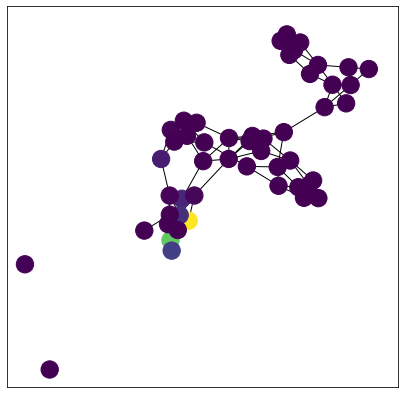

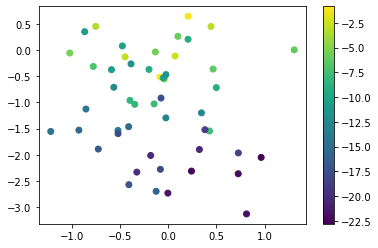

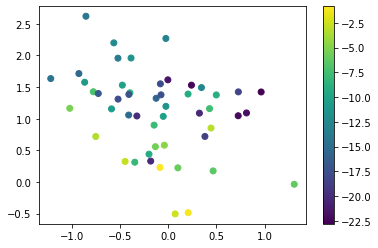

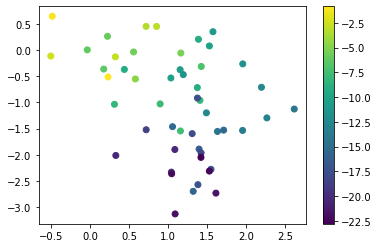

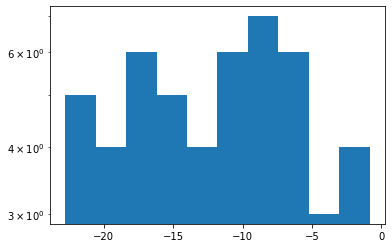

Center of mass coordinates:
[1.9239707730714546e-17, 2.971941023350216e-17, -1.8173581005576974e-17]
Total mass:
1.0
[3, 0.08228474767843713, 0.9999243026210151]


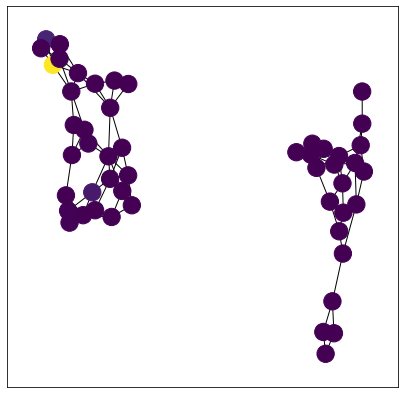

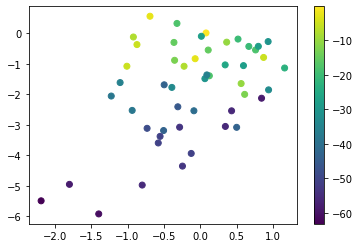

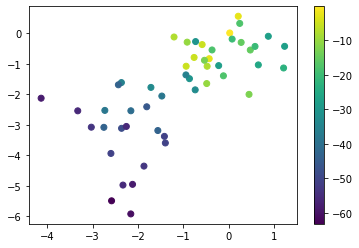

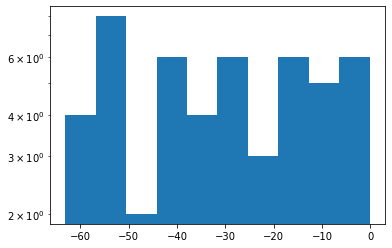

Center of mass coordinates:
[1.3877787800986943e-17, 2.7755575588151076e-17, 2.428612865344295e-17]
Total mass:
1.0
[3, 0.24173797957757076, 0.9893423665706111]


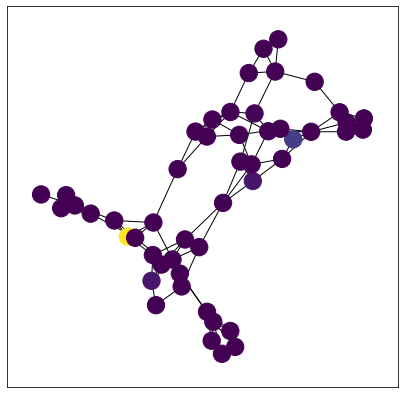

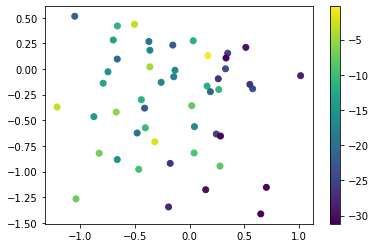

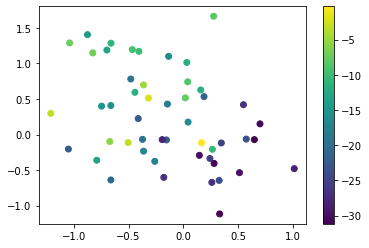

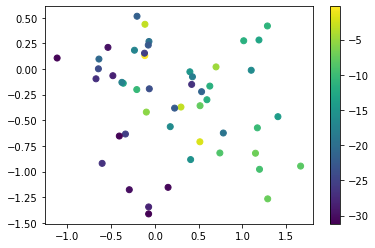

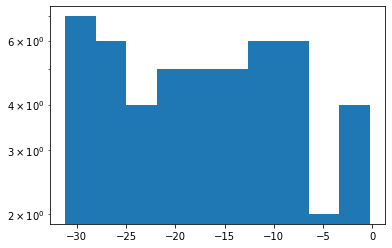

Center of mass coordinates:
[8.545400841979397e-18, -4.4438796265268805e-17, 3.980251092518703e-17]
Total mass:
1.0000000000000002
[3, 0.4605136330999222, 0.99985933911631]


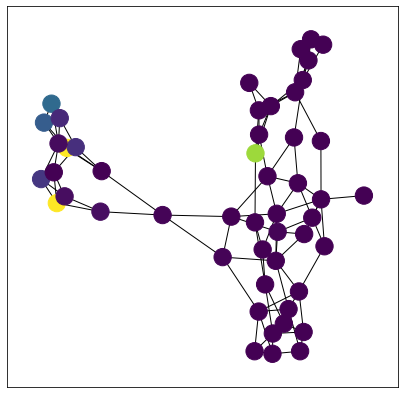

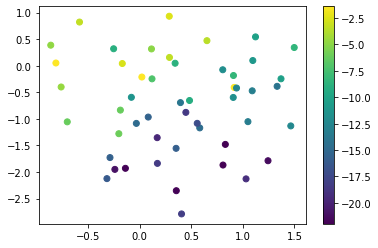

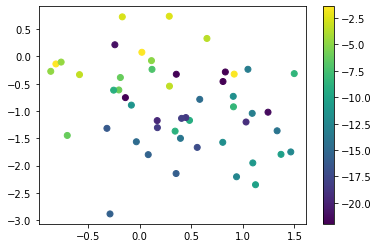

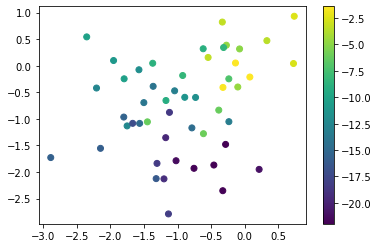

Center of mass coordinates:
[2.794300242519712e-18, -2.290451804464457e-17, -3.419028525519948e-17]
Total mass:
1.0000000000000002
[3, 0.214278220659177, 0.9581681733256917]


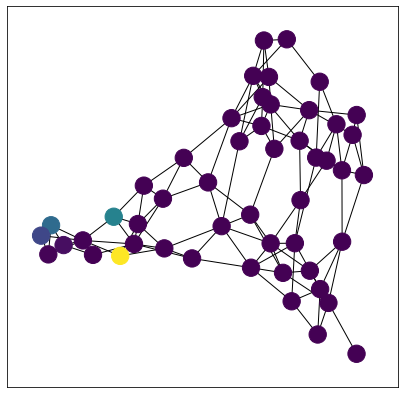

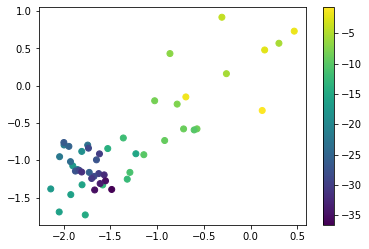

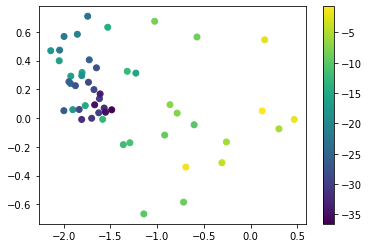

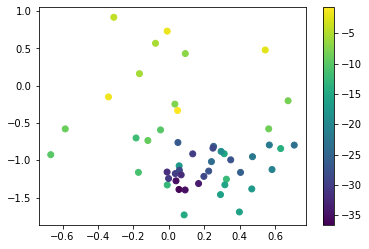

Center of mass coordinates:
[1.8218341143130086e-17, -6.992814882240449e-18, 1.0629853253336097e-17]
Total mass:
0.9999999999999999
[3, 0.028730046287635314, 0.9698967136829608]


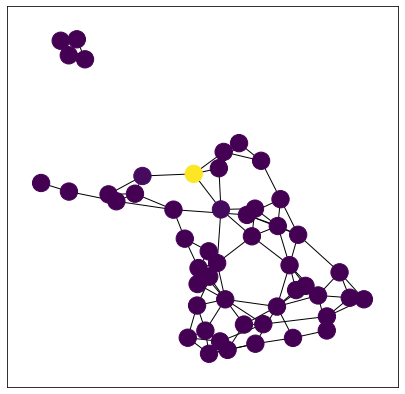

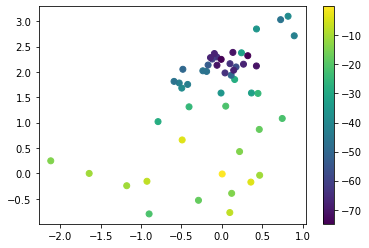

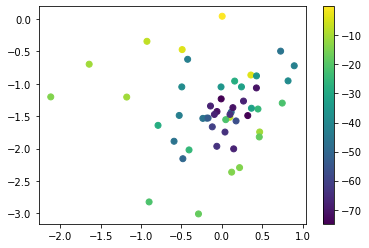

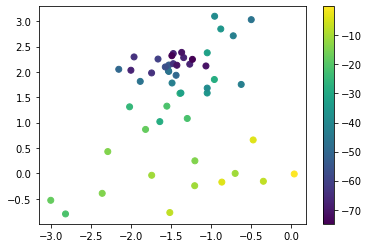

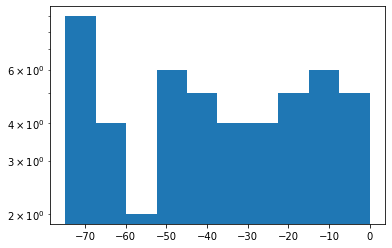

Center of mass coordinates:
[1.557153344367666e-32, -2.168404344968395e-19, -8.023096076392884e-18]
Total mass:
1.0
[3, 0.46250371721467126, 0.9931160799247368]


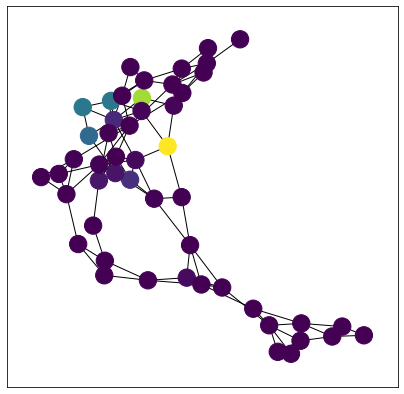

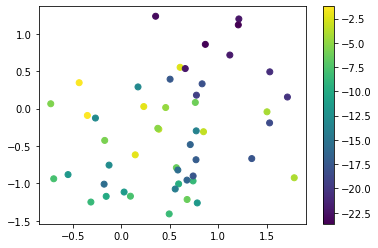

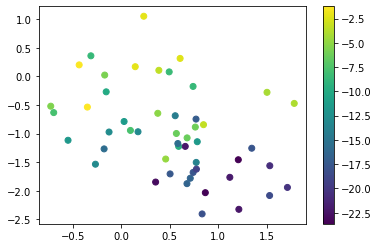

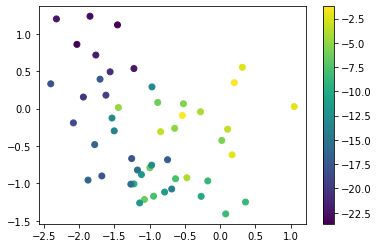

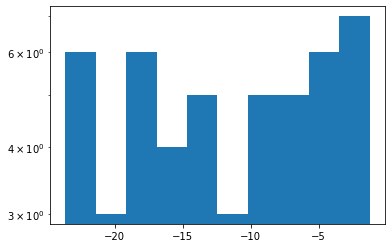

Center of mass coordinates:
[-5.233801647889326e-17, -2.004948899974813e-18, -1.1212676626900928e-17]
Total mass:
0.9999999999999997
[3, 0.32880076919160556, 0.9606346793700604]


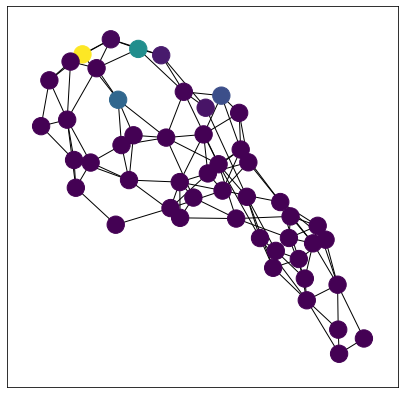

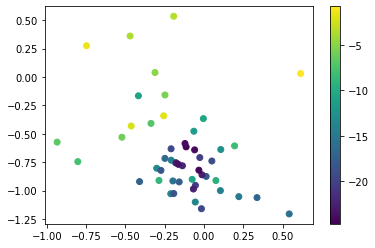

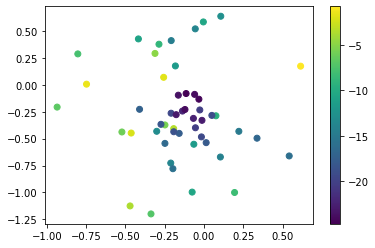

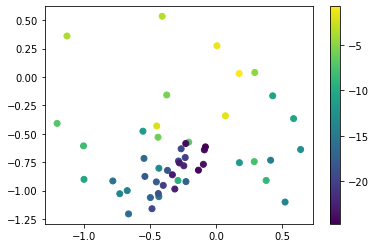

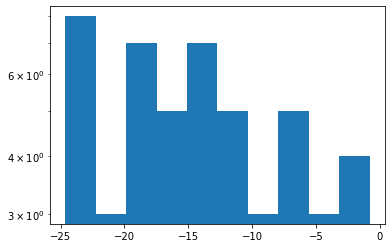

Center of mass coordinates:
[1.2930012045850009e-17, -1.0694827972155045e-17, -4.6413455252782655e-17]
Total mass:
1.0000000000000002
[3, 0.06647641906082091, 0.962282367707368]


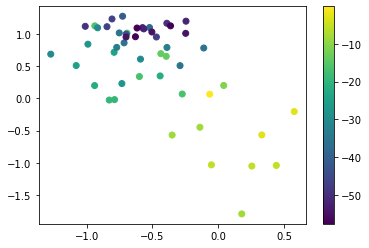

Center of mass coordinates:
[1.1275705151197979e-17, -1.040833940347232e-17, 2.4069287164565528e-17]
Total mass:
0.9999999999999999
[3, 0.2667244625311804, 0.9548445075897473]


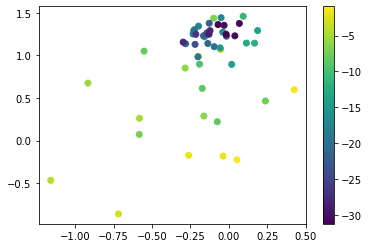

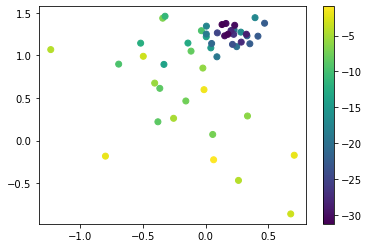

Center of mass coordinates:
[6.882235826916164e-18, 9.656468990357524e-18, 2.5545711553531957e-17]
Total mass:
1.0


In [5]:
def visualize_graph(F, color, color_map="viridis"):
    '''Summary plot of the graph F'''
    G = to_networkx(F, to_undirected=True)
    plt.figure(figsize=(7,7))
    plt.xticks([])
    plt.yticks([])
    nx.draw_networkx(G, pos=nx.spring_layout(G, seed=42), with_labels=False,
                     node_color=color, cmap=color_map)
    plt.show()


for clu, gra, para in zip(clusters[0:10], cluster_graphs[0:10], cluster_params[0:10]):
    print(para)
    visualize_graph(gra, clu[:,0])
    cluster_diagnostics(clu)

### The machine learning part
This is whole graph regression. Inspired by graph classification here: https://colab.research.google.com/drive/1I8a0DfQ3fI7Njc62__mVXUlcAleUclnb?usp=sharing

I use MSE as a loss on the parameter I choose to predict.

In [6]:
num_node_features = 7

class GCN(torch.nn.Module):
    def __init__(self, hidden_channels):
        super(GCN, self).__init__()
        torch.manual_seed(12345)
        self.conv1 = GCNConv(num_node_features, hidden_channels)
        self.conv2 = GCNConv(hidden_channels, hidden_channels)
        self.conv3 = GCNConv(hidden_channels, hidden_channels)
        self.lin = Linear(hidden_channels, 1)

    def forward(self, x, edge_index, batch):
        # 1. Obtain node embeddings 
        x = self.conv1(x, edge_index)
        x = x.relu()
        x = self.conv2(x, edge_index)
        x = x.relu()
        x = self.conv3(x, edge_index)

        # 2. Readout layer
        x = global_mean_pool(x, batch)  # [batch_size, hidden_channels]

        # 3. Apply a final classifier
        x = F.dropout(x, p=0.5, training=self.training)
        x = self.lin(x)
        
        return x

model = GCN(hidden_channels=64)
print(model)

GCN(
  (conv1): GCNConv(7, 64)
  (conv2): GCNConv(64, 64)
  (conv3): GCNConv(64, 64)
  (lin): Linear(in_features=64, out_features=1, bias=True)
)


In [7]:
from torch_geometric.loader import DataLoader
from random import shuffle

l = round(0.5*len(cluster_graphs))
shuffle(cluster_graphs)
cluster_graphs_train = cluster_graphs[0:l]
cluster_graphs_test = cluster_graphs[l:len(cluster_graphs)]

train_loader = DataLoader(cluster_graphs_train, batch_size=64, shuffle=True) #train and test the same for now
test_loader = DataLoader(cluster_graphs_test, batch_size=64, shuffle=False)

for step, data in enumerate(train_loader):
    print(f'Step {step + 1}:')
    print('=======')
    print(f'Number of graphs in the current batch: {data.num_graphs}')
    print(data)
    print()

model = GCN(hidden_channels=64)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
criterion = torch.nn.MSELoss()
    
def train():
    model.train()

    for data in train_loader:  # Iterate in batches over the training dataset.
         out = model(data.x, data.edge_index, data.batch)  # Perform a single forward pass.
         loss = criterion(out, data.y)  # Compute the loss.
         loss.backward()  # Derive gradients.
         optimizer.step()  # Update parameters based on gradients.
         optimizer.zero_grad()  # Clear gradients.

def test(loader):
     model.eval()

     losses = []
     for data in loader:  # Iterate in batches over the training/test dataset.
         out = model(data.x, data.edge_index, data.batch)
         loss = criterion(out, data.y)
         loss = loss.detach().numpy()
         losses.append(loss)
         ####print(out.detach().numpy())
         ####print(data.y.detach().numpy())
         ###s = (out.detach().numpy()[:,0] - data.y.detach().numpy())
         ###print(loss - np.mean(s*s)) #should be 0 but it's not... how is the loss calculated???
         ###print(s)
         ####loss = loss - np.mean(s*s)
     return np.mean(np.array(losses)) #correct / len(loader.dataset)  # Derive ratio of correct predictions.


epochs = range(1, 171)
trainMSEs = []
testMSEs = []
for epoch in epochs:
    train()
    train_acc = test(train_loader)
    test_acc = test(test_loader)
    print(f'Epoch: {epoch:03d}, Train MSE: {train_acc:.4f}, Test MSE: {test_acc:.4f}')
    trainMSEs.append(train_acc)
    testMSEs.append(test_acc)
    

Step 1:
Number of graphs in the current batch: 64
DataBatch(x=[3200, 7], edge_index=[2, 12800], y=[64], batch=[3200], ptr=[65])

Step 2:
Number of graphs in the current batch: 64
DataBatch(x=[3200, 7], edge_index=[2, 12800], y=[64], batch=[3200], ptr=[65])

Step 3:
Number of graphs in the current batch: 64
DataBatch(x=[3200, 7], edge_index=[2, 12800], y=[64], batch=[3200], ptr=[65])

Step 4:
Number of graphs in the current batch: 64
DataBatch(x=[3200, 7], edge_index=[2, 12800], y=[64], batch=[3200], ptr=[65])

Step 5:
Number of graphs in the current batch: 64
DataBatch(x=[3200, 7], edge_index=[2, 12800], y=[64], batch=[3200], ptr=[65])

Step 6:
Number of graphs in the current batch: 64
DataBatch(x=[3200, 7], edge_index=[2, 12800], y=[64], batch=[3200], ptr=[65])

Step 7:
Number of graphs in the current batch: 64
DataBatch(x=[3200, 7], edge_index=[2, 12800], y=[64], batch=[3200], ptr=[65])

Step 8:
Number of graphs in the current batch: 52
DataBatch(x=[2600, 7], edge_index=[2, 10400], y

/opt/anaconda3/envs/pygfun/lib/python3.9/site-packages/torch/nn/modules/loss.py:520: UserWarning: Using a target size (torch.Size([64])) that is different to the input size (torch.Size([64, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/opt/anaconda3/envs/pygfun/lib/python3.9/site-packages/torch/nn/modules/loss.py:520: UserWarning: Using a target size (torch.Size([52])) that is different to the input size (torch.Size([52, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch: 001, Train MSE: 0.1383, Test MSE: 0.1399
Epoch: 002, Train MSE: 0.0263, Test MSE: 0.0290
Epoch: 003, Train MSE: 0.0205, Test MSE: 0.0243
Epoch: 004, Train MSE: 0.0148, Test MSE: 0.0151
Epoch: 005, Train MSE: 0.0048, Test MSE: 0.0049
Epoch: 006, Train MSE: 0.0011, Test MSE: 0.0012
Epoch: 007, Train MSE: 0.0017, Test MSE: 0.0018
Epoch: 008, Train MSE: 0.0006, Test MSE: 0.0007
Epoch: 009, Train MSE: 0.0008, Test MSE: 0.0008
Epoch: 010, Train MSE: 0.0003, Test MSE: 0.0004
Epoch: 011, Train MSE: 0.0005, Test MSE: 0.0005
Epoch: 012, Train MSE: 0.0020, Test MSE: 0.0020
Epoch: 013, Train MSE: 0.0008, Test MSE: 0.0008
Epoch: 014, Train MSE: 0.0004, Test MSE: 0.0003
Epoch: 015, Train MSE: 0.0004, Test MSE: 0.0004
Epoch: 016, Train MSE: 0.0003, Test MSE: 0.0003
Epoch: 017, Train MSE: 0.0006, Test MSE: 0.0006
Epoch: 018, Train MSE: 0.0004, Test MSE: 0.0004
Epoch: 019, Train MSE: 0.0005, Test MSE: 0.0005
Epoch: 020, Train MSE: 0.0003, Test MSE: 0.0003
Epoch: 021, Train MSE: 0.0003, Test MSE:

In [17]:
plt.plot(epochs, np.log(trainMSEs))
plt.plot(epochs, np.log(testMSEs))
plt.xlabel('epoch')
plt.ylabel('log MSE')

Text(0, 0.5, 'log MSE')

It looks like it's pretty good at learning $\theta_2$ at least